In [1]:
import torch
torch.cuda.is_available()
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
def load_data(batch_size=128, labels=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Single channel normalization
    ])
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if labels is not None:
        train_indices = [i for i, label in enumerate(train_set.targets) if label in labels]
        test_indices = [i for i, label in enumerate(test_set.targets) if label in labels]
        train_set = torch.utils.data.Subset(train_set, train_indices)
        test_set = torch.utils.data.Subset(test_set, test_indices)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def load_data_cifar10(batch_size=128, labels=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 3-channel normalization
    ])
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    if labels is not None:
        train_indices = [i for i, label in enumerate(train_set.targets) if label in labels]
        test_indices = [i for i, label in enumerate(test_set.targets) if label in labels]
        train_set = torch.utils.data.Subset(train_set, train_indices)
        test_set = torch.utils.data.Subset(test_set, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader




Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


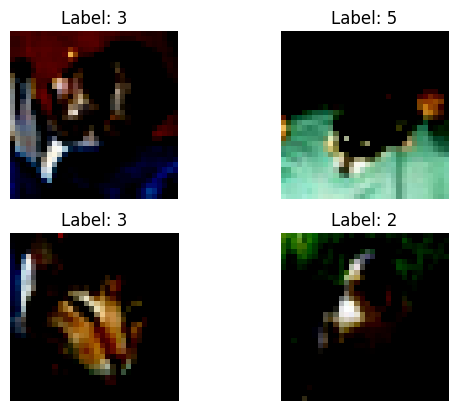

In [3]:

train_loader, test_loader = load_data_cifar10()

def visualize_mnist():
    f, axarr = plt.subplots(2,2)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 4:  # We only want to plot the first 4 images
            break
        ax = axarr[i // 2, i % 2]
        ax.imshow(images[0].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[0].item()}')
        ax.axis('off')
    plt.show()

def visualize_cifar10():
    f, axarr = plt.subplots(2, 2)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 4:  # We only want to plot the first 4 images
            break
        ax = axarr[i // 2, i % 2]
        ax.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
        ax.set_title(f'Label: {labels[0].item()}')
        ax.axis('off')
    plt.show()

visualize_cifar10()

In [4]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
class NetCifar10(nn.Module):
    def __init__(self):
        super(NetCifar10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max logit
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)


In [7]:
model = NetCifar10().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [8]:
####### NAIVE TRAINING #######
naive_accs = []
dataloaders = [load_data_cifar10(labels=[0, 1, 2]), load_data_cifar10(labels=[3, 4, 5]), load_data_cifar10(labels=[6, 7, 8, 9])]

for id, (train_loader, test_loader) in enumerate(dataloaders):
    avg_acc = 0
    print("Training on task: ", id)
    print("Train loader: ", train_loader)

    for epoch in range(1, 2):
        train(model, device, train_loader, optimizer, epoch)
        
    for id_test, (train_loader, test_loader) in enumerate(dataloaders):
        print("Testing on task: ", id_test)
        acc = test(model, device, test_loader)
        avg_acc = avg_acc + acc 

    naive_accs.append(avg_acc / len(dataloaders))
    print("Avg acc: ", avg_acc / len(dataloaders))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training on task:  0
Train loader:  <torch.utils.data.dataloader.DataLoader object at 0x79866e91bbc0>
Train Epoch: 1 [0/15000 (0%)]	Loss: 2.341599
Train Epoch: 1 [12800/15000 (85%)]	Loss: 0.900115
Testing on task:  0
Test set: Average loss: 0.8178, Accuracy: 1969/3000 (66%)

Testing on task:  1
Test set: Average loss: 8.4983, Accuracy: 0/3000 (0%)

Testing on task:  2
Test set: Average loss: 8.8418, Accuracy: 0/4000 (0%)

Avg acc:  21.87777777777778
Training on task:  1
Train loader:  <torch.utils.data.dataloader.DataLoader object at 0x79866e999910>
Train Epoch: 1 [0/15000 (0%)]	Loss: 8.503437
Train Epoch: 1 [12800/15000 (85%)]	Loss: 1.048467
Testing on task:  0
Test set: Average loss: 9.1698, Accuracy: 0/3000 (0%)

Testing on task:  1
Test set: Average loss: 1.

In [12]:
model = NetCifar10().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
max_grad_norm = 2.0  
optimizer = optim.Adam(model.parameters(), lr=0.01)
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 10
def on_task_update(task_id, dataloader):

    model.train()
    optimizer.zero_grad()

    # Accumulating gradients using DataLoader
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = F.cross_entropy(output, y_batch)
        loss.backward()

    fisher_dict[task_id] = {}
    optpar_dict[task_id] = {}

    # Gradients accumulated can be used to calculate Fisher information
    for name, param in model.named_parameters():
        optpar_dict[task_id][name] = param.data.clone()
        fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

clamp_min = -1.0 
clamp_max = 1.0

def train_ewc(model, device, task_id, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        output = model(data)
        loss = F.cross_entropy(output, target)
        if torch.isnan(loss):
            print(f"NaN loss encountered at in cross entropy : batch {batch_idx}, epoch {epoch}")
            continue
        ### magic here! :-)
        for task in range(task_id):
            for name, param in model.named_parameters():
                fisher = fisher_dict[task][name]
                optpar = optpar_dict[task][name]
                loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
        if torch.isnan(loss):
            print(f"NaN loss encountered at in fisher : batch {batch_idx}, epoch {epoch}")
            continue
            
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


In [13]:
dataloaders = [
    load_data_cifar10(labels=[0, 1, 2]),
    load_data_cifar10(labels=[3, 4, 5]),
    load_data_cifar10(labels=[6, 7, 8, 9]),
]

ewc_accs = []
for id, (train_loader, test_loader) in enumerate(dataloaders):
    avg_acc = 0
    print("Training on task: ", id)

    for epoch in range(1, 2):
        train_ewc(model, device, id, train_loader, optimizer, epoch)
    on_task_update(id, train_loader)

    for id_test, (_, test_loader) in enumerate(dataloaders):
        print("Testing on task: ", id_test)
        acc = test(model, device, test_loader)
        avg_acc = avg_acc + acc

    print("Avg acc: ", avg_acc / 3)
    ewc_accs.append(avg_acc / 3)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training on task:  0
Train Epoch: 1 	Loss: 0.490840
Testing on task:  0
Test set: Average loss: 0.6590, Accuracy: 2212/3000 (74%)

Testing on task:  1
Test set: Average loss: 11.6848, Accuracy: 0/3000 (0%)

Testing on task:  2
Test set: Average loss: 16.3165, Accuracy: 0/4000 (0%)

Avg acc:  24.57777777777778
Training on task:  1
Train Epoch: 1 	Loss: 1.027223
Testing on task:  0
Test set: Average loss: 30.1822, Accuracy: 0/3000 (0%)

Testing on task:  1
Test set: Average loss: 0.9492, Accuracy: 1582/3000 (53%)

Testing on task:  2
Test set: Average loss: 46.0149, Accuracy: 0/4000 (0%)

Avg acc:  17.57777777777778
Training on task:  2
Train Epoch: 1 	Loss: 0.774468
Testing on task:  0
Test set: Average loss: 30.1481, Accuracy: 0/3000 (0%)

Testing on task:  1
Te

In [14]:
def visualize_fisher_filters(model, fisher_dict, title_prefix="Layer"):
    """
    For each convolutional layer, plot the per-filter importance (Fisher).
    We assume 'fisher_dict' has the same parameter names as 'model'.
    """
    # Gather all conv layers
    conv_params = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            # We'll collect info for each conv's name: "features.0", etc.
            conv_params.append((name, module))

    # For each conv layer, get the corresponding fisher values
    for i, (layer_name, conv_module) in enumerate(conv_params):
        # Grab the weight parameter name for this layer
        weight_name = f"{layer_name}.weight"
        if weight_name not in fisher_dict:
            continue

        # Fisher shape: (out_channels, in_channels, kernel_size, kernel_size)
        fisher_weights = fisher_dict[weight_name].detach().cpu().numpy()

        out_channels, in_channels, kH, kW = fisher_weights.shape

        # We'll create a figure with out_channels subplots (e.g., 8x8 if out_channels=64)
        # But for large out_channels, you might want a different layout
        cols = int(np.ceil(np.sqrt(out_channels)))
        rows = int(np.ceil(out_channels / cols))

        fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
        axs = axs.flatten()

        for j in range(out_channels):
            ax = axs[j]
            # For each filter j, we have shape (in_channels, kH, kW).
            # We can either sum across in_channels or show the maximum channel
            filter_fisher = fisher_weights[j]
            # Summation across input channels
            filter_fisher_agg = filter_fisher.sum(axis=0)  # shape (kH, kW)

            im = ax.imshow(filter_fisher_agg, cmap='hot')
            ax.axis('off')
            ax.set_title(f"Filter {j}")

        # Hide any extra subplots
        for j in range(out_channels, len(axs)):
            axs[j].axis('off')

        fig.suptitle(f"{title_prefix} {layer_name} Fisher Importance")
        cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
        cbar.set_label('Fisher Information')
        plt.tight_layout()
        plt.show()



/tmp/ipykernel_8756/2796402650.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


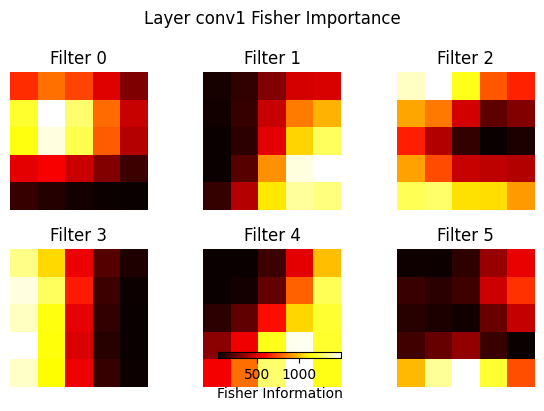

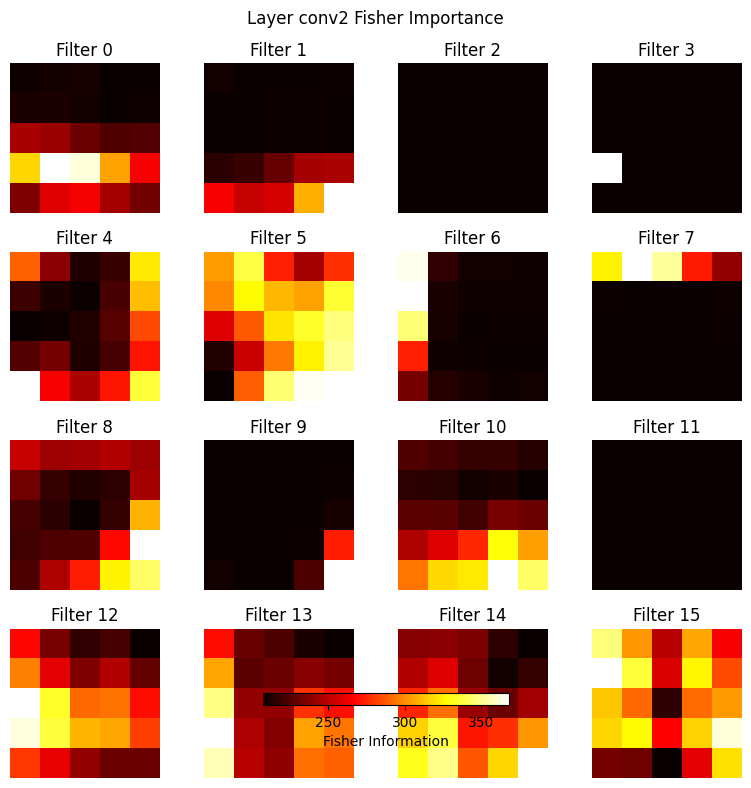

In [15]:
visualize_fisher_filters(model, fisher_dict[0])

/tmp/ipykernel_8756/2187645978.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


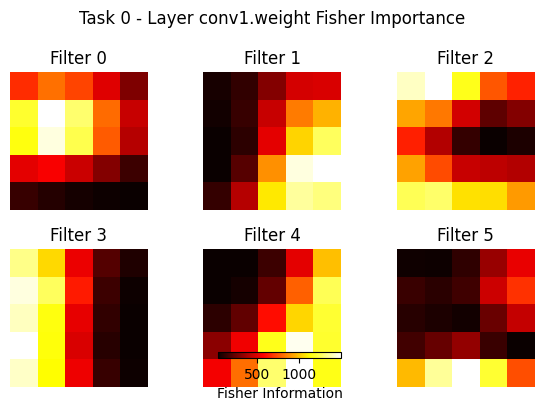

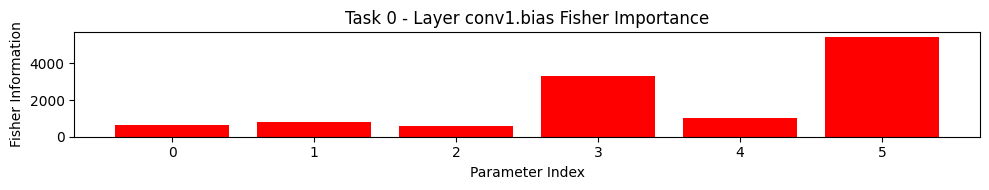

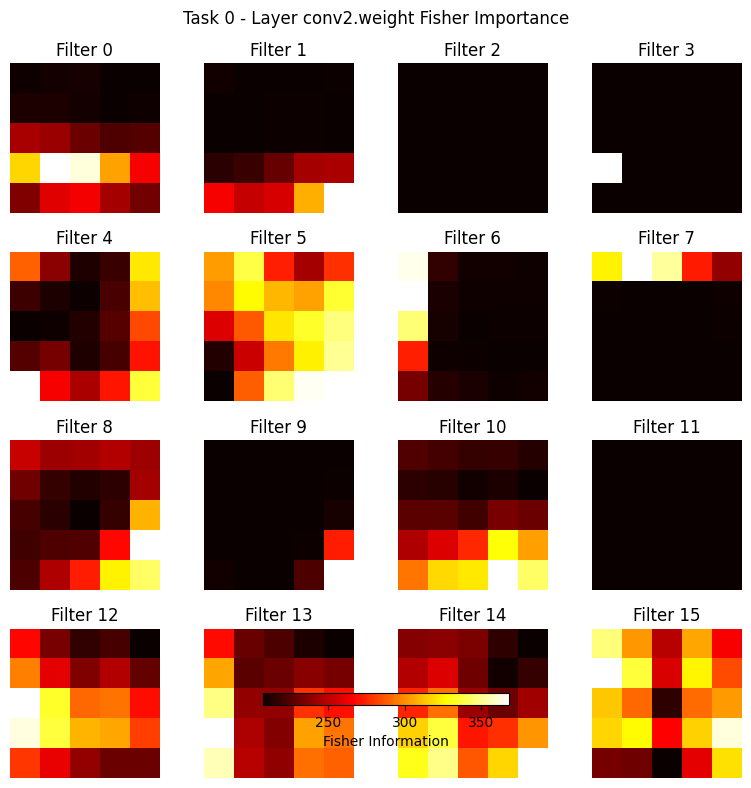

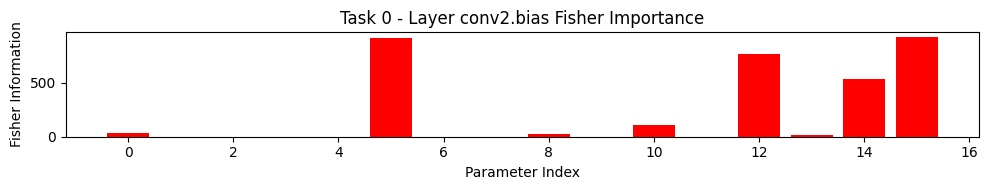

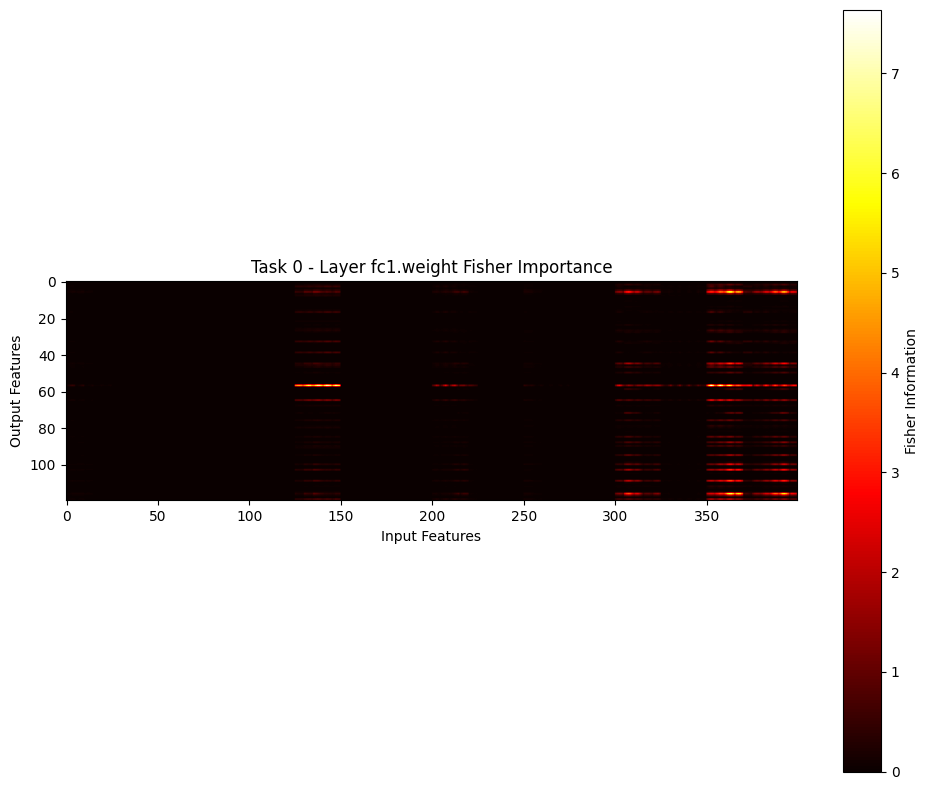

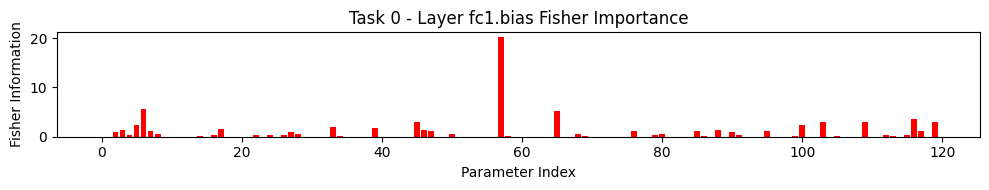

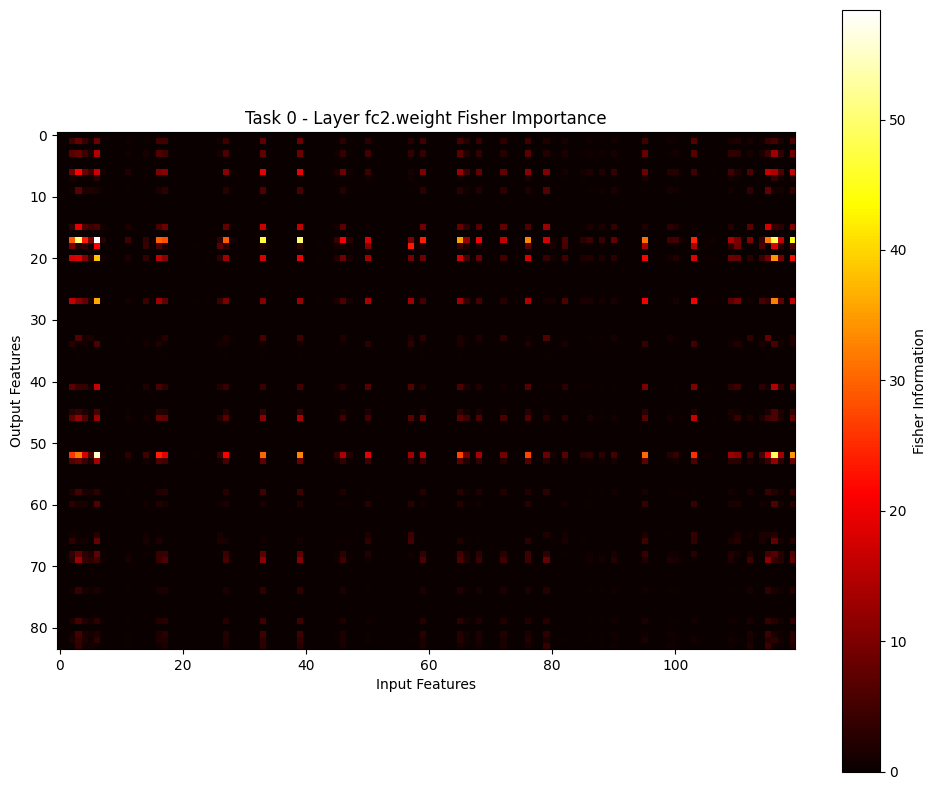

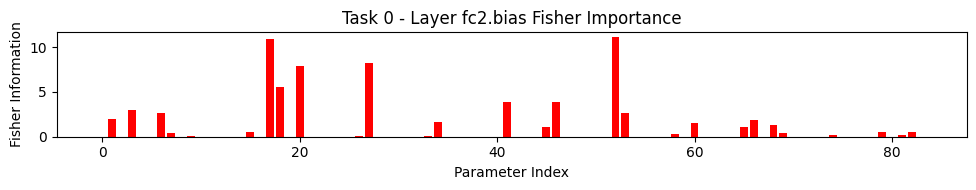

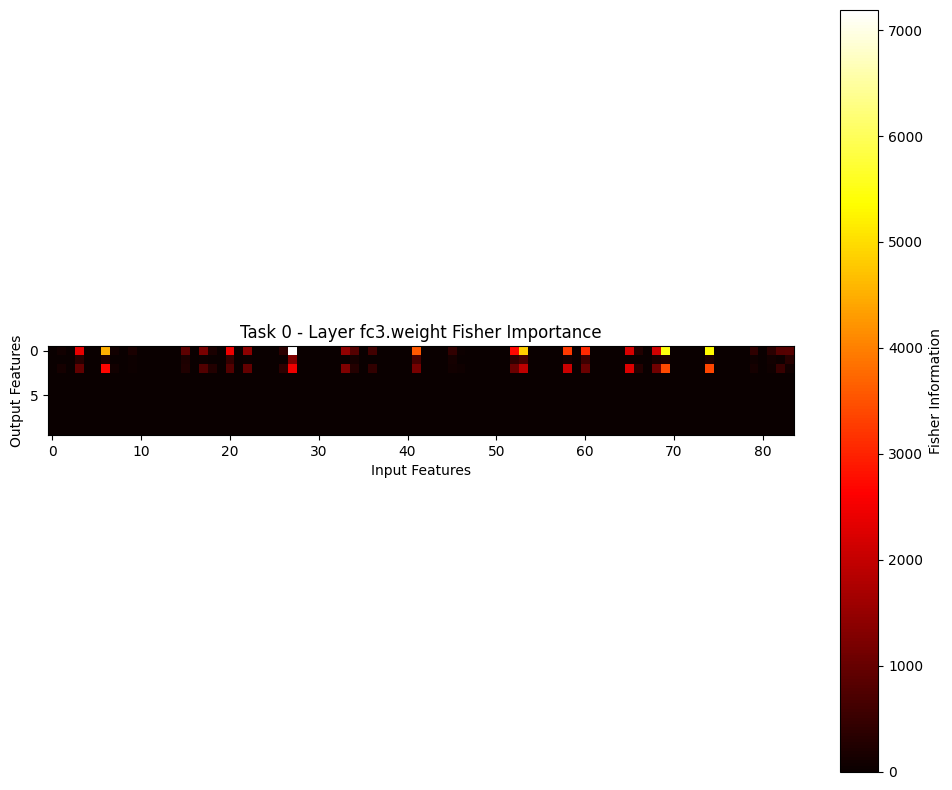

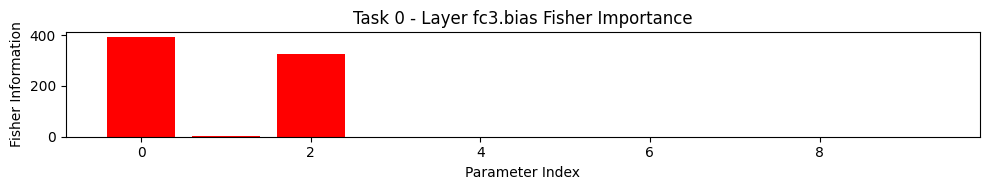

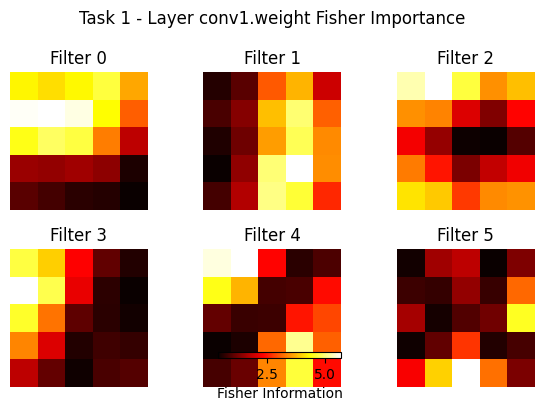

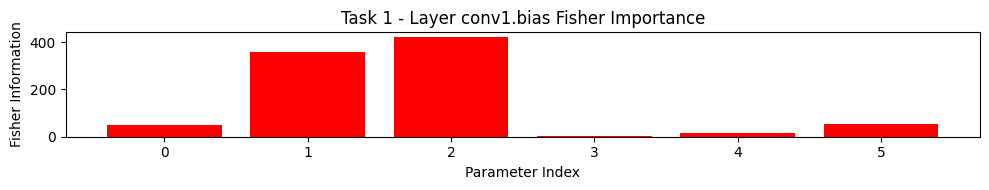

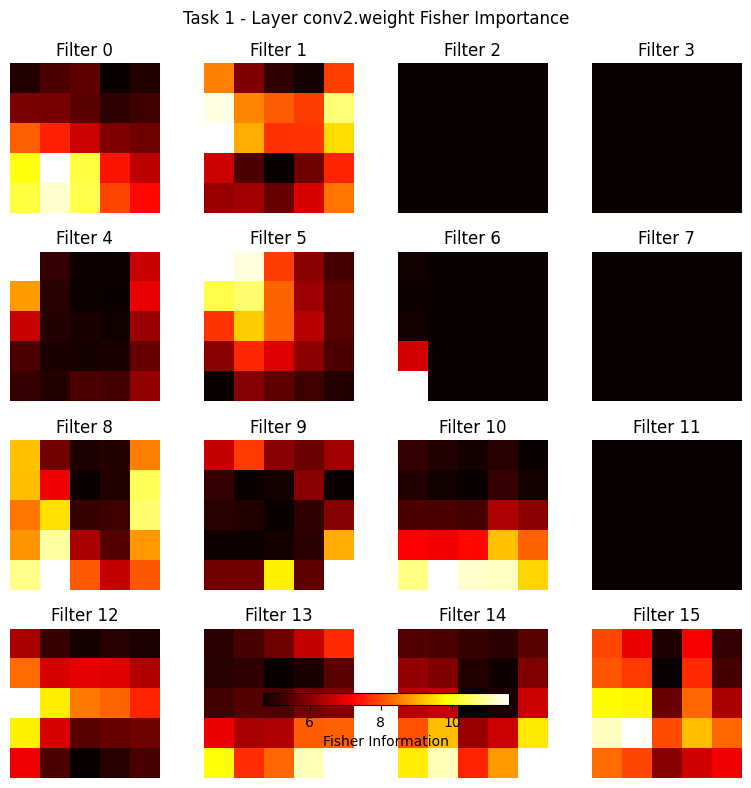

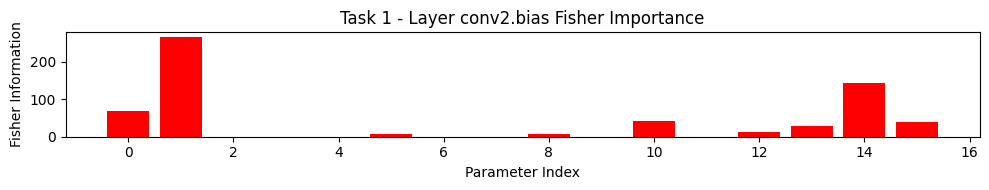

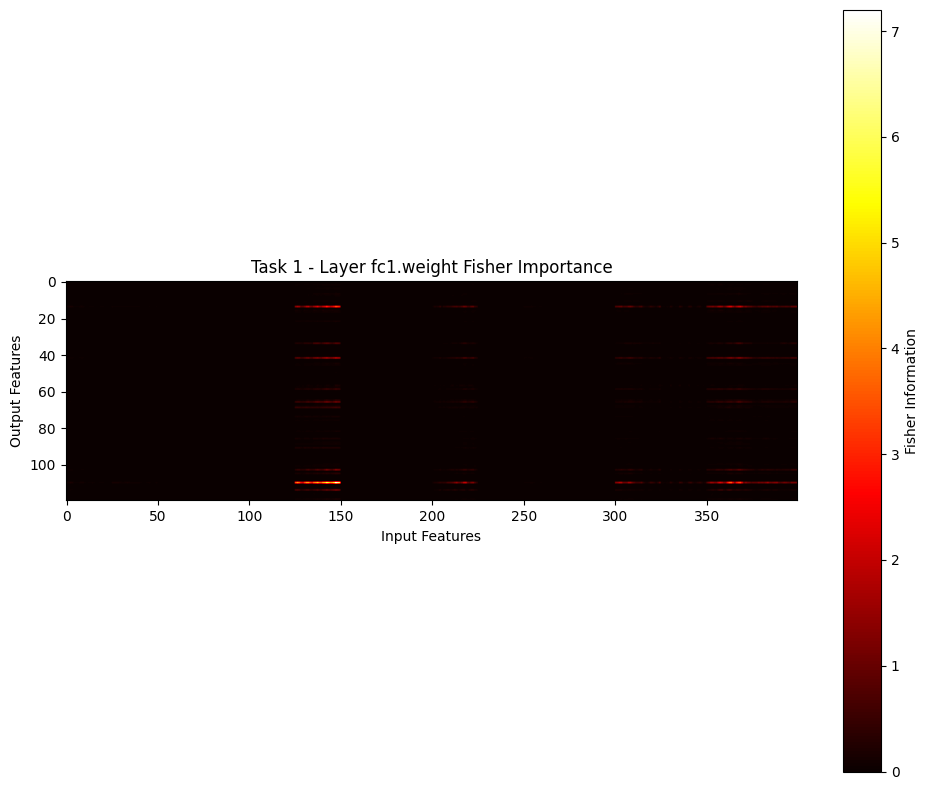

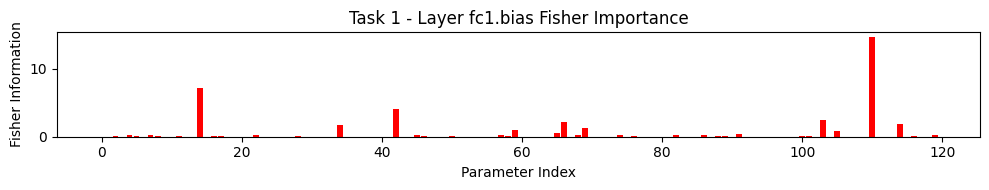

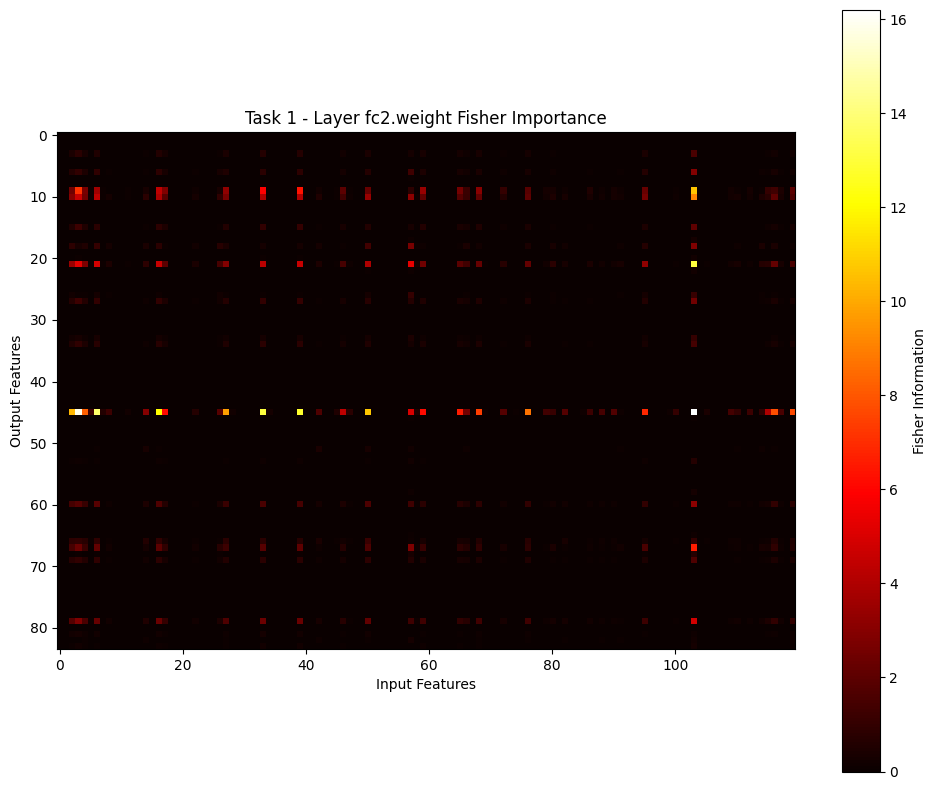

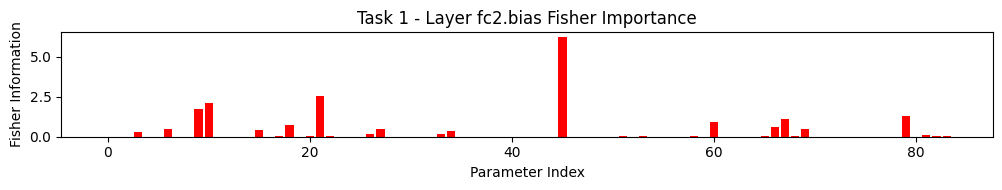

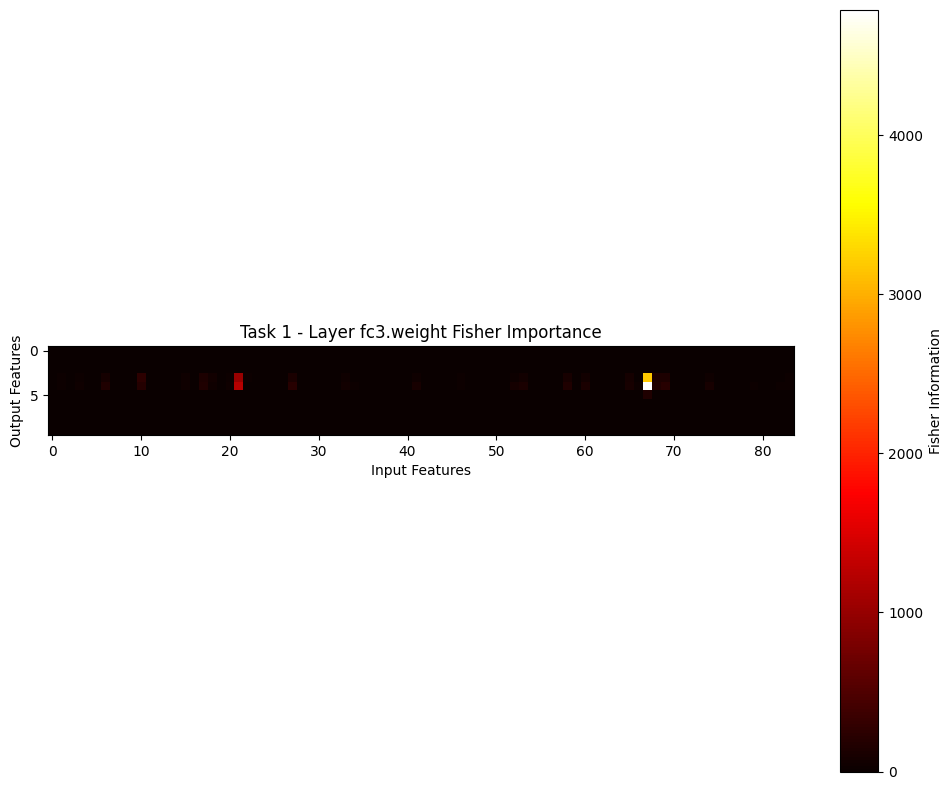

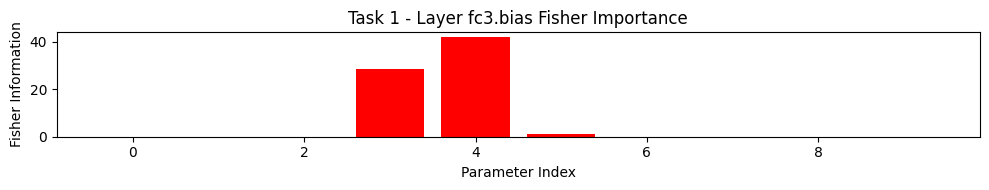

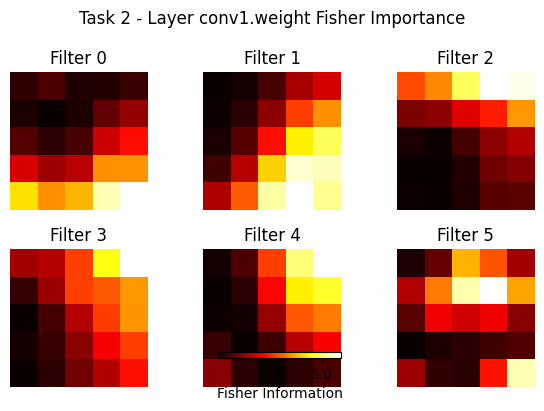

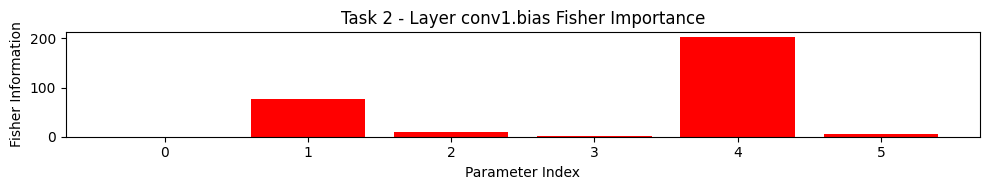

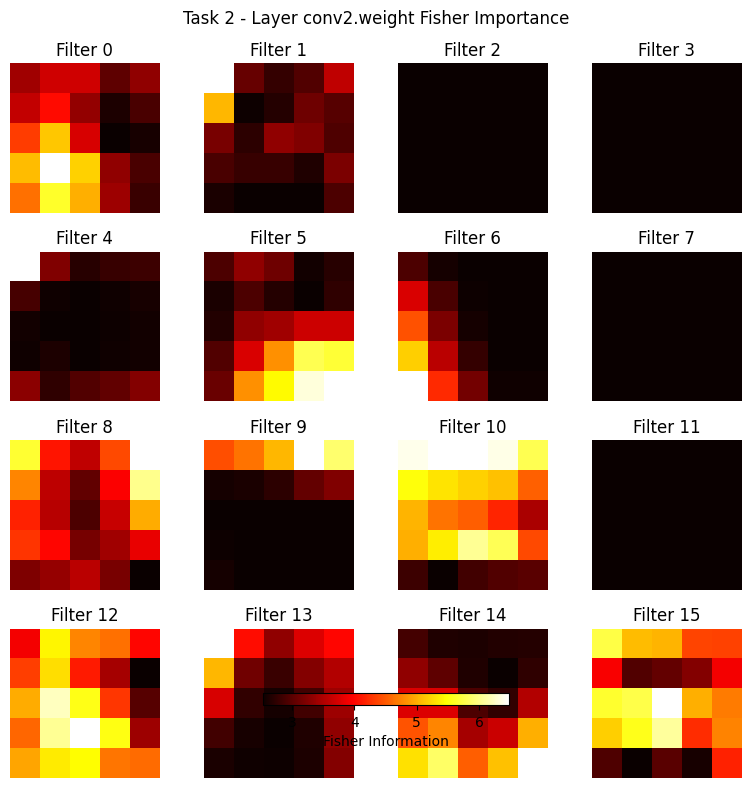

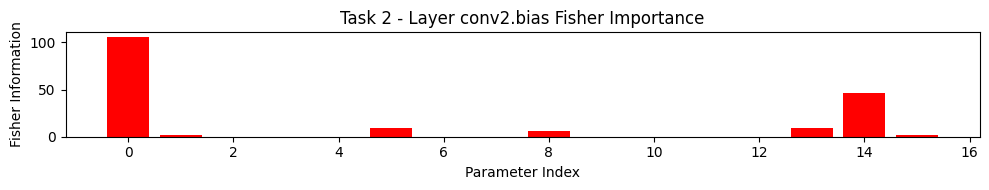

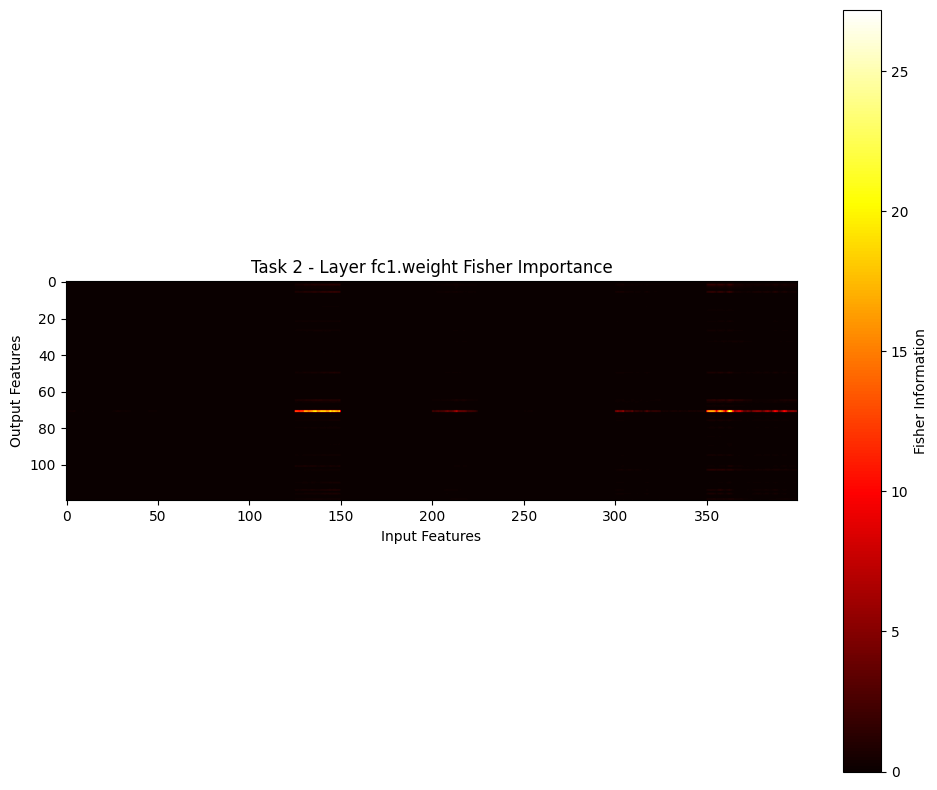

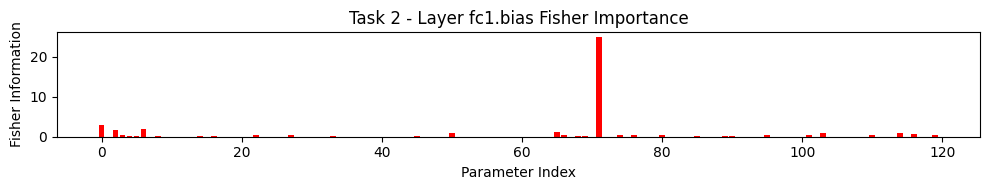

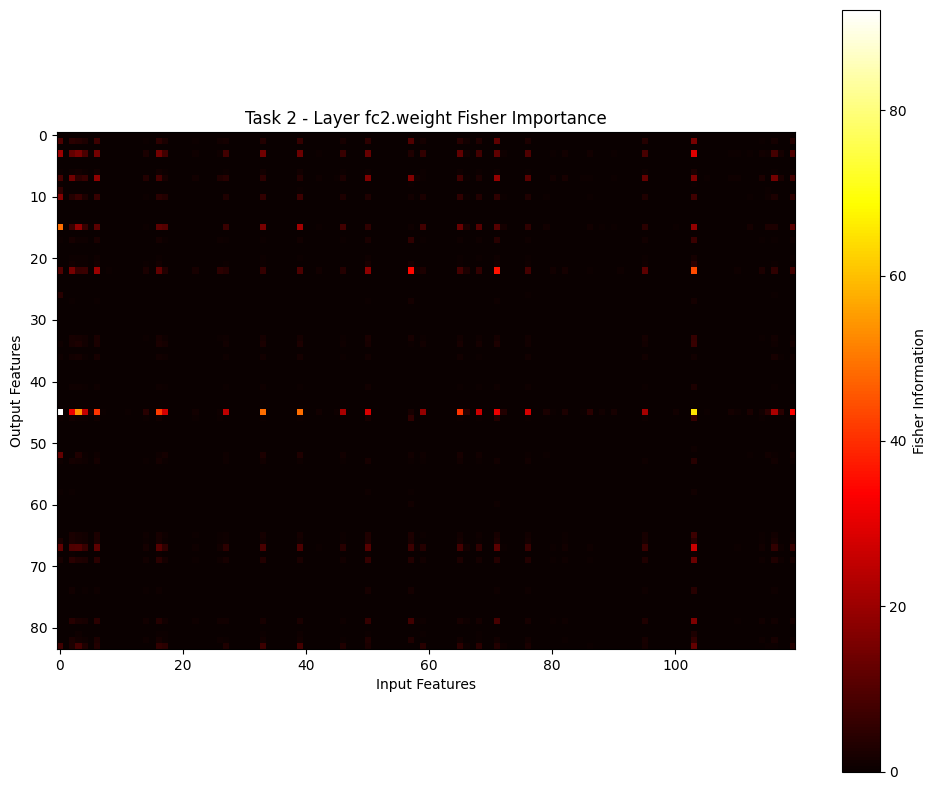

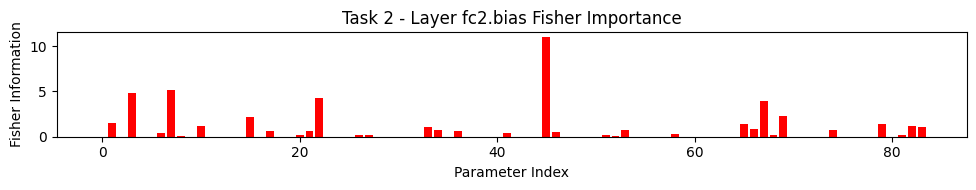

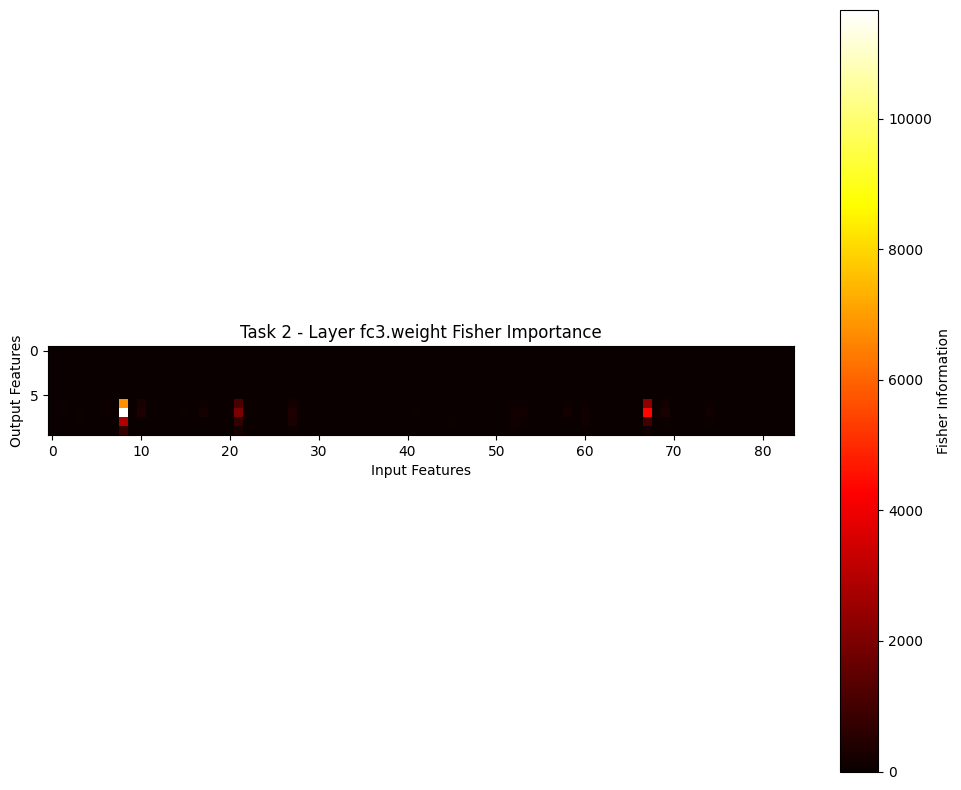

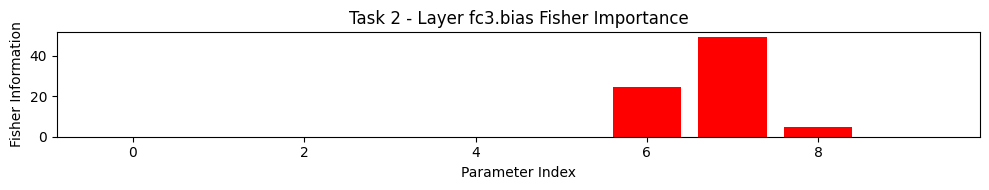

In [16]:
def visualize_fisher_all_layers(model, fisher_dict, title_prefix="Layer", header_prefix="Task"):
    """
    Visualize Fisher information for all layers of the model.
    Supports convolutional, fully connected (linear), and other layers.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Iterate through all layers in the model
    for name, module in model.named_modules():
        for param_name, param in module.named_parameters(recurse=False):
            full_param_name = f"{name}.{param_name}" if name else param_name

            # Skip if this parameter is not in the Fisher dictionary
            if full_param_name not in fisher_dict:
                continue

            # Get Fisher information for the parameter
            fisher_values = fisher_dict[full_param_name].detach().cpu().numpy()

            # Determine visualization based on parameter shape
            param_shape = fisher_values.shape
            if len(param_shape) == 4:  # Conv2D weights: (out_channels, in_channels, kH, kW)
                out_channels, in_channels, kH, kW = param_shape

                # Create subplots for the filters
                cols = int(np.ceil(np.sqrt(out_channels)))
                rows = int(np.ceil(out_channels / cols))

                fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
                axs = axs.flatten()

                for i in range(out_channels):
                    ax = axs[i]
                    filter_fisher = fisher_values[i]
                    filter_fisher_agg = filter_fisher.sum(axis=0)  # Aggregate across input channels
                    im = ax.imshow(filter_fisher_agg, cmap='hot')
                    ax.axis('off')
                    ax.set_title(f"Filter {i}")

                for i in range(out_channels, len(axs)):
                    axs[i].axis('off')

                fig.suptitle(f"{header_prefix} - {title_prefix} {full_param_name} Fisher Importance")
                cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
                cbar.set_label('Fisher Information')
                plt.tight_layout()
                plt.show()

            elif len(param_shape) == 2:  # Linear weights: (out_features, in_features)
                fig, ax = plt.subplots(figsize=(10, 8))
                im = ax.imshow(fisher_values, cmap='hot')
                ax.set_title(f"{header_prefix} - {title_prefix} {full_param_name} Fisher Importance")
                ax.set_xlabel("Input Features")
                ax.set_ylabel("Output Features")
                cbar = fig.colorbar(im, ax=ax)
                cbar.set_label('Fisher Information')
                plt.tight_layout()
                plt.show()

            elif len(param_shape) == 1:  # Biases or 1D parameters
                fig, ax = plt.subplots(figsize=(10, 2))
                ax.bar(range(param_shape[0]), fisher_values, color='red')
                ax.set_title(f"{header_prefix} - {title_prefix} {full_param_name} Fisher Importance")
                ax.set_xlabel("Parameter Index")
                ax.set_ylabel("Fisher Information")
                plt.tight_layout()
                plt.show()

            else:  # Catch-all for unexpected shapes
                print(f"Skipping visualization for {full_param_name} (shape {param_shape})")


for i in range(3):
    plt.show()
    visualize_fisher_all_layers(model, fisher_dict[i], header_prefix=f"Task {i}")
    